# Imports

In [1]:
from matplotlib import pyplot as plt
import functools
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import numpy as np
import openml
import pandas as pd
from openml.tasks import TaskType
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, FunctionTransformer 
import random
import torch

## Creating our own h5 training and evaluation files compatible with the dataloader

In [134]:
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import openml

In [152]:
import importlib
import preprocessing
importlib.reload(preprocessing) #il faut reload l'importer des que tu fais un changement a la classe

<module 'preprocessing' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\preprocessing.py'>

In [ ]:
from preprocessing import create_h5_prior_from_dataset

Create the files

In [ ]:
create_h5_prior_from_dataset(179, "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5","h5_files/TEST_500_adult_database_100_80_rows_13_features.h5" , num_tasks = 500, total_rows = 100, train_rows=80, num_features=13)

c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:33: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)


table size =  (48842, 14)
{'age': '2', 'workclass': 'State-gov', 'fnlwgt': 77516.0, 'education': 'Bachelors', 'education-num': 13, 'marital-status': 'Never-married', 'occupation': 'Adm-clerical', 'relationship': 'Not-in-family', 'race': 'White', 'sex': 'Male', 'capitalgain': '1', 'capitalloss': '0', 'hoursperweek': '2', 'native-country': 'United-States'}
y size (48842,)
X_train  (34189, 14)
y train  (34189,)
X test  (14653, 14)
y test  (14653,)

Saved tasks here here  to h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5

Saved tasks here here  to h5_files/TEST_500_adult_database_100_80_rows_13_features.h5


Check the files

In [52]:
def visualize_h5_prior(file_path, num_tasks_to_show=5, plot_distributions=True):
    """
    Visualize an HDF5 prior file created for PFNs.
    
    Parameters:
        file_path (str): Path to the HDF5 file
        num_tasks_to_show (int): How many tasks to inspect in detail
        plot_distributions (bool): Whether to plot feature distributions for sample tasks
    """
    with h5py.File(file_path, "r") as f:
        print("HDF5 file keys:", list(f.keys()))
        X = f['X'][:]  # shape: (num_tasks, total_rows, num_features)
        y = f['y'][:]
        num_datapoints = f['num_datapoints'][:]
        train_test_split = f['single_eval_pos'][:]
        num_tasks = X.shape[0]
        
        print(f"\nTotal tasks: {num_tasks}")
        print(f"Shape of X: {X.shape}")
        print(f"Shape of y: {y.shape}")
        
        for task_idx in range(min(num_tasks_to_show, num_tasks)):
            print(f"\n=== Task {task_idx} ===")
            X_task = X[task_idx]
            y_task = y[task_idx]
            rows, num_features = X_task.shape
            print(f"Number of rows: {rows}, Number of features: {num_features}")
            print(f"Train rows: {train_test_split[task_idx]}, Test rows: {rows - train_test_split[task_idx]}")
            
            # Convert to pandas DataFrame for easier analysis
            df_task = pd.DataFrame(X_task, columns=[f"f{i}" for i in range(num_features)])
            df_task['target'] = y_task
            
            # Feature stats
            feature_stats = df_task.describe().T[['min', 'max', 'mean', 'std']]
            print("\nFeature stats:")
            print(feature_stats)
            
            # Optional: show first row
            print("\nSample row:")
            print(df_task.iloc[0])
            
            # Optional: plot distributions
            if plot_distributions:
                plt.figure(figsize=(12, 3 * num_features))
                for i, col in enumerate(df_task.columns[:-1]):  # skip target
                    plt.subplot(num_features, 1, i + 1)
                    sns.histplot(df_task[col], bins=20, kde=True)
                    plt.title(f"Task {task_idx} - Feature {col} distribution")
                plt.tight_layout()
                plt.show()

In [156]:
file_path = "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5"  # or your file
with h5py.File(file_path, "r") as f:
    # List the keys
    print(f)
    print("Keys:", list(f.keys()))

    X = f['X'][:]
    print(f"X shape {X.shape}")
    y = f['y'][:]
    print(f"y shape {y.shape}")
    num_datapoint = f['num_datapoints']
    print(f"num_datapoints shape {num_datapoint.shape}")
    train_test_split = f['single_eval_pos']
    print(f"train_test_split shape {train_test_split.shape}")
    
  

<HDF5 file "TRAIN_500_adult_database_100_80_rows_13_features.h5" (mode r)>
Keys: ['X', 'max_num_classes', 'num_datapoints', 'num_features', 'single_eval_pos', 'y']
X shape (350, 100, 13)
y shape (350, 100)
num_datapoints shape (350,)
train_test_split shape (350,)


## Training base model on this dataset

In [190]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(model)
importlib.reload(attentions) 
importlib.reload(train)
from model import NanoTabPFNModel

In [197]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories.append(history)

Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 2.6s | loss 0.4742 | ROC AUC: 0.7441
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 4.9s | loss 0.4940 | ROC AUC: 0.7648
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 7.3s | loss 0.4673 | ROC AUC: 0.8167
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 9.6s | loss 0.4239 | ROC AUC: 0.8294
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 12.0s | loss 0.4176 | ROC AUC: 0.8311
Finish

In [198]:
save_path = f"adult_models/nanotabpfn_original.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories:
    history.to_csv(f"adult_histories/nanotabpfn_original.csv", index = False)

Saved model to adult_models/nanotabpfn_original.pt


### Loss curves and training time

In [199]:
import importlib
import visualisation
import model
importlib.reload(visualisation)
importlib.reload(model)

<module 'model' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\model.py'>

In [200]:
loaded_history = pd.read_csv("adult_histories/nanotabpfn_original.csv")
model_histories = {"Original": loaded_history} 
                   

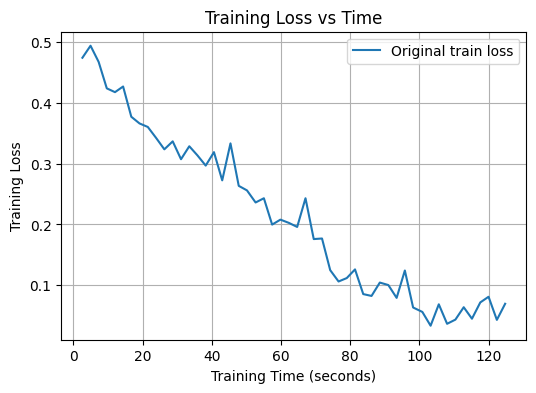

In [201]:
from visualisation import plot_metric
plot_metric("train loss vs time", model_histories)

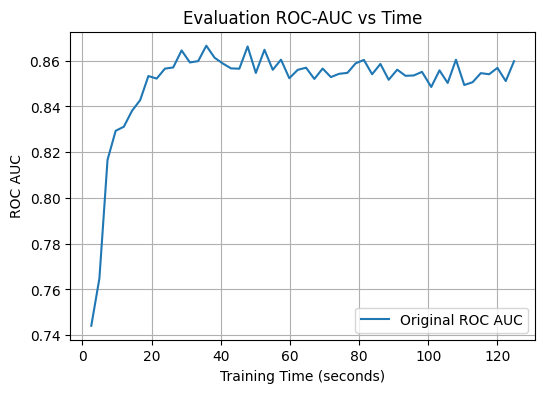

In [202]:
plot_metric("ROC vs time", model_histories)

In [204]:
from visualisation import summarize_training_times_and_memory_usage
training_times = summarize_training_times_and_memory_usage(model_histories)
training_times

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Original,124.783765,0.094843,78.775916,1578.686139


## Training model with attention from scratch

In [203]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_scratch = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2, 
            attention_type= "Scratch"
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_scratch.append(history)

Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 2.7s | loss 0.4742 | ROC AUC: 0.7555
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 5.2s | loss 0.4869 | ROC AUC: 0.7636
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 7.6s | loss 0.4764 | ROC AUC: 0.7986
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 10.1s | loss 0.4282 | ROC AUC: 0.8059
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 12.6s | loss 0.4171 | ROC AUC: 0.8331
Finis

In [205]:
save_path = f"adult_models/nanotabpfn_scratch_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_scratch:
    history.to_csv(f"adult_histories/nanotabpfn_scratch_attention.csv", index = False)

Saved model to adult_models/nanotabpfn_scratch_attention.pt


### Loss Curves and training time 

In [206]:
loaded_history_scratch = pd.read_csv("adult_histories/nanotabpfn_scratch_attention.csv")
model_histories["Scratch"] = loaded_history_scratch 
                   

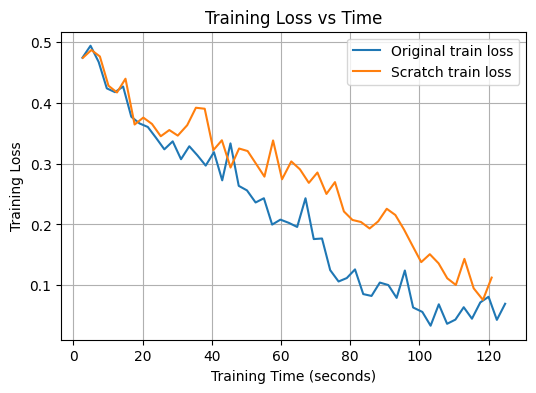

In [207]:
plot_metric("train loss vs time", model_histories)

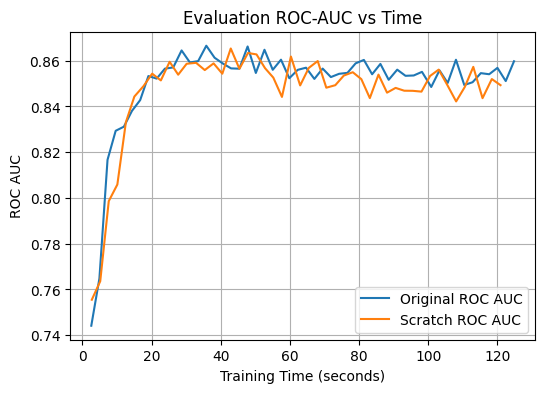

In [208]:
plot_metric("ROC vs time", model_histories)

In [209]:
training_times = summarize_training_times_and_memory_usage(model_histories)
training_times

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Original,124.783765,0.094843,78.775916,1578.686139
1,Scratch,120.882672,0.099534,22.876160,1737.019989


## Training Model with sparse local attention

In [210]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sparse = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2, 
            attention_type= "Sparse"
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_sparse.append(history)

Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 2.7s | loss 0.4690 | ROC AUC: 0.7692
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 5.1s | loss 0.4743 | ROC AUC: 0.7852
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 7.6s | loss 0.4892 | ROC AUC: 0.8273
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 10.1s | loss 0.4204 | ROC AUC: 0.8330
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 12.7s | loss 0.3850 | ROC AUC: 0.8397
Finis

In [211]:
save_path = f"adult_models/nanotabpfn_sparse_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_sparse:
    history.to_csv(f"adult_histories/nanotabpfn_sparse_attention.csv", index = False)

Saved model to adult_models/nanotabpfn_sparse_attention.pt


### Loss curves and training time 

In [212]:
loaded_history_sparse = pd.read_csv("adult_histories/nanotabpfn_sparse_attention.csv")
model_histories["Sparse"] = loaded_history_sparse 

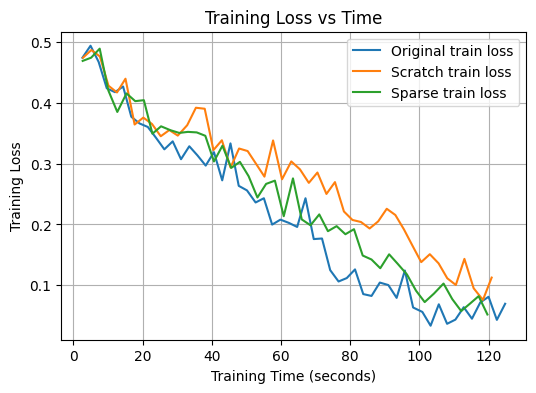

In [213]:
plot_metric("train loss vs time", model_histories)

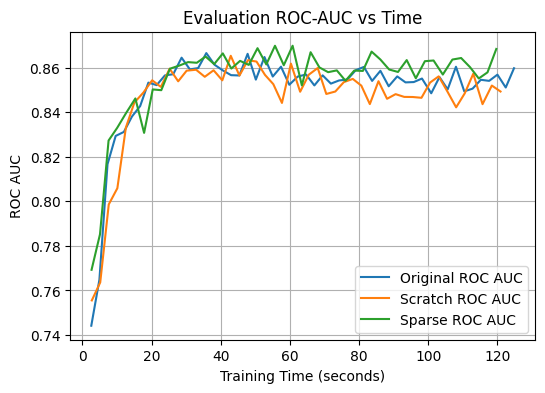

In [214]:
plot_metric("ROC vs time", model_histories)

In [215]:
training_times = summarize_training_times_and_memory_usage(model_histories)
training_times

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Original,124.783765,0.094843,78.775916,1578.686139
1,Scratch,120.882672,0.099534,22.876160,1737.019989
2,Sparse,119.661810,0.101017,22.862314,1736.795354


## Train model with sparse attention but with different window sizes

In [218]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(model)
importlib.reload(attentions) 
importlib.reload(train)
from model import NanoTabPFNModel

In [219]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sparse_small = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2, 
            attention_type= "Sparse"
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_sparse_small.append(history)

local window size:  4
local window size:  4
local window size:  4
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 2.7s | loss 0.4692 | ROC AUC: 0.7694
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 5.1s | loss 0.4794 | ROC AUC: 0.7856
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 7.6s | loss 0.4538 | ROC AUC: 0.8309
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 10.1s | loss 0.4850 | ROC AUC: 0.8264
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_

In [220]:
save_path = f"adult_models/nanotabpfn_sparse_attention_small.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_sparse_small:
    history.to_csv(f"adult_histories/nanotabpfn_sparse_attention_small.csv", index = False)

Saved model to adult_models/nanotabpfn_sparse_attention_small.pt


In [5]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(model)
importlib.reload(attentions) 
importlib.reload(train)
from model import NanoTabPFNModel

In [ ]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sparse_big = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2, 
            attention_type= "Sparse"
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_sparse_big.append(history)

local window size:  30
local window size:  30
local window size:  30
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 2.9s | loss 0.4684 | ROC AUC: 0.7693
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 5.3s | loss 0.4728 | ROC AUC: 0.7829
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 7.8s | loss 0.4640 | ROC AUC: 0.8301
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 10.3s | loss 0.4190 | ROC AUC: 0.8323
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  di

In [7]:
save_path = f"adult_models/nanotabpfn_sparse_attention_big.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_sparse_big:
    history.to_csv(f"adult_histories/nanotabpfn_sparse_attention_big.csv", index = False)

Saved model to adult_models/nanotabpfn_sparse_attention_big.pt


In [9]:
loaded_history_sparse_small = pd.read_csv("adult_histories/nanotabpfn_sparse_attention_small.csv")
loaded_history_sparse = pd.read_csv("adult_histories/nanotabpfn_sparse_attention.csv")
loaded_history_sparse_big = pd.read_csv("adult_histories/nanotabpfn_sparse_attention_big.csv")
model_histories_sparse = { "Window 8": loaded_history_sparse, 
                          "Window 4": loaded_history_sparse_small, 
                          "window 30": loaded_history_sparse_big}

In [15]:
from visualisation import plot_metric, summarize_training_times_and_memory_usage

### Loss curves and training times

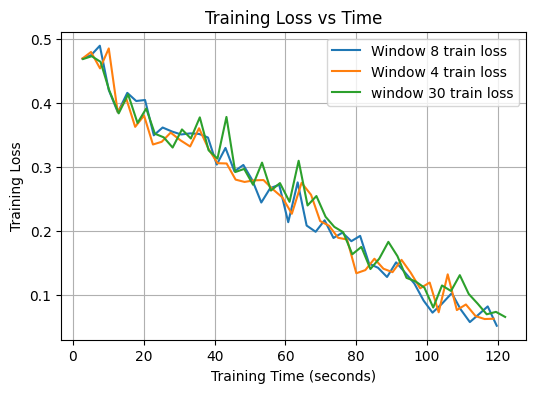

In [12]:
plot_metric("train loss vs time", model_histories_sparse)

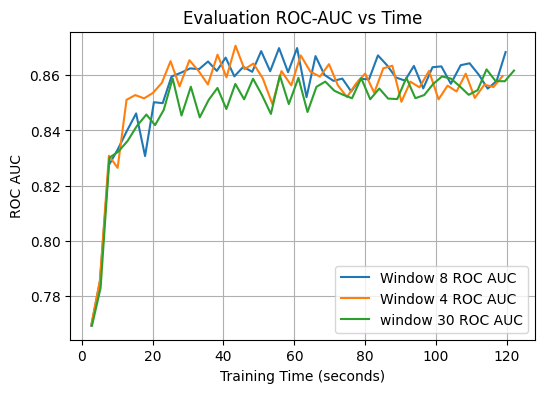

In [13]:
plot_metric("ROC vs time", model_histories_sparse)

In [16]:
training_times_sparse = summarize_training_times_and_memory_usage(model_histories_sparse)
training_times_sparse

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Window 8,119.661810,0.101017,22.862314,1736.795354
1,Window 4,118.786350,0.101913,22.862291,1736.554541
2,window 30,122.038066,0.099864,22.862336,1739.359829


## Local Attention from Scratch using a Sliding Window 

In [22]:
import importlib
import model
import attentions  
import train
importlib.reload(model)
importlib.reload(attentions) 
importlib.reload(train)
from model import NanoTabPFNModel

In [23]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_local = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2, 
            attention_type= "Local"
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_local.append(history)

window_size 8
window_size 8
window_size 8
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 3.2s | loss 0.4744 | ROC AUC: 0.7557
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 6.1s | loss 0.4863 | ROC AUC: 0.7768
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 9.0s | loss 0.4774 | ROC AUC: 0.7983
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 12.0s | loss 0.4283 | ROC AUC: 0.8228
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 1

In [24]:
save_path = f"adult_models/nanotabpfn_local_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_local:
    history.to_csv(f"adult_histories/nanotabpfn_local_attention.csv", index = False)

Saved model to adult_models/nanotabpfn_local_attention.pt


In [25]:
loaded_history_sparse = pd.read_csv("adult_histories/nanotabpfn_sparse_attention.csv")
loaded_history_local = pd.read_csv("adult_histories/nanotabpfn_local_attention.csv")
model_histories_compare = { "Sparse": loaded_history_sparse, 
                          "Local": loaded_history_local
                          }

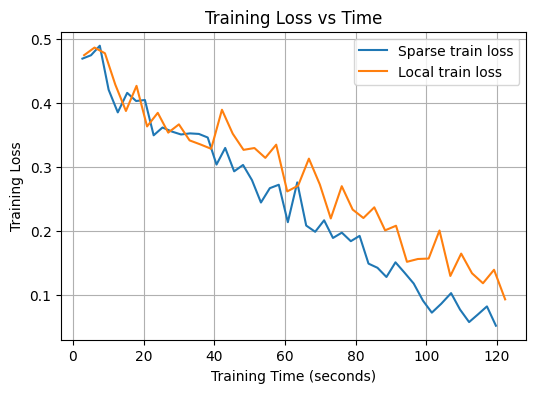

In [26]:
plot_metric("train loss vs time", model_histories_compare)

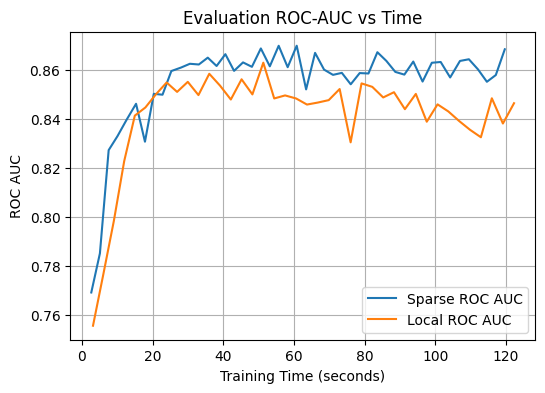

In [27]:
plot_metric("ROC vs time", model_histories_compare)

In [28]:
training_times_compare = summarize_training_times_and_memory_usage(model_histories_compare)
training_times_compare

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Sparse,119.661810,0.101017,22.862314,1736.795354
1,Local,122.271673,0.122692,22.876224,2813.820685


## Pooling Attention

In [57]:
import importlib
import model
import attentions  
import train
importlib.reload(attentions) 
importlib.reload(model)
importlib.reload(train)
from model import NanoTabPFNModel

In [58]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_pool = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5", 
        num_steps=2000, 
        batch_size=32, 
        device=device)
    eval_loader = PriorDumpDataLoader(
        "h5_files/TRAIN_500_adult_database_100_80_rows_13_features.h5",
        num_steps=150,      # use all data once
        batch_size=1,
        device=device
    )

    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=2, 
            attention_type= "Pooling"
        )
    model, history = train(model, prior, eval_loader = eval_loader, lr=4e-3, steps_per_eval=25)
    history = pd.DataFrame(history)
    histories_pool.append(history)

we are pooling with  4
we are pooling with  4
we are pooling with  4
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 2.1s | loss 0.4844 | ROC AUC: 0.7413
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 4.1s | loss 0.4876 | ROC AUC: 0.7446
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 6.3s | loss 0.4820 | ROC AUC: 0.7696
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dict_keys(['ROC AUC'])
time 9.0s | loss 0.4637 | ROC AUC: 0.7840
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
Finished iteration over all stored datasets! 
metric keys:  dic

In [59]:
save_path = f"adult_models/nanotabpfn_pooling_attention.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_pool:
    history.to_csv(f"adult_histories/nanotabpfn_pooling_attention.csv", index = False)

Saved model to adult_models/nanotabpfn_pooling_attention.pt


In [60]:
loaded_history_scratch = pd.read_csv("adult_histories/nanotabpfn_scratch_attention.csv")
loaded_history_pool = pd.read_csv("adult_histories/nanotabpfn_pooling_attention.csv")
model_histories_pool = { "Scratch": loaded_history_scratch, 
                          "Pooling": loaded_history_pool
                          }

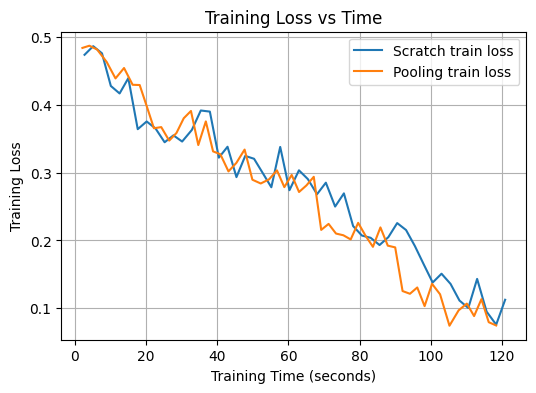

In [61]:
plot_metric("train loss vs time", model_histories_pool)

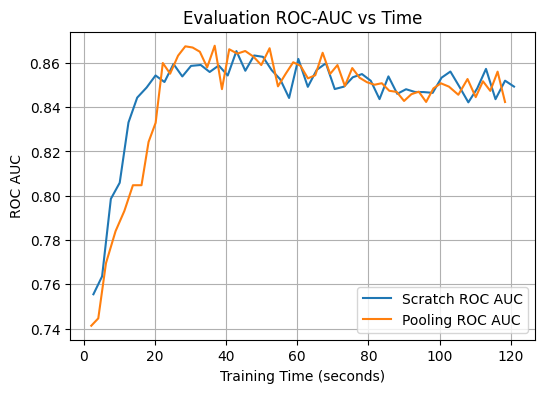

In [62]:
plot_metric("ROC vs time", model_histories_pool)

In [63]:
training_times_pool = summarize_training_times_and_memory_usage(model_histories_pool)
training_times_pool

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Scratch,120.882672,0.099534,22.876160,1737.019989
1,Pooling,118.359967,0.082084,625.319871,1839.702509


## Final Comparisons

In [73]:
import importlib
import visualisation
import attentions
importlib.reload(visualisation)
importlib.reload(attentions)

<module 'attentions' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\attentions.py'>

In [81]:
loaded_history_original = pd.read_csv("adult_histories/nanotabpfn_original.csv")
loaded_history_scratch = pd.read_csv("adult_histories/nanotabpfn_scratch_attention.csv")
loaded_history_sparse = pd.read_csv("adult_histories/nanotabpfn_sparse_attention.csv")
loaded_history_local = pd.read_csv("adult_histories/nanotabpfn_local_attention.csv")
loaded_history_pool = pd.read_csv("adult_histories/nanotabpfn_pooling_attention.csv")
model_histories_final = { "Original" : loaded_history_original,
                        "Scratch": loaded_history_scratch,
                         "Sparse" : loaded_history_sparse,
                         "Local" : loaded_history_local,
                          "Pooling": loaded_history_pool
                          }

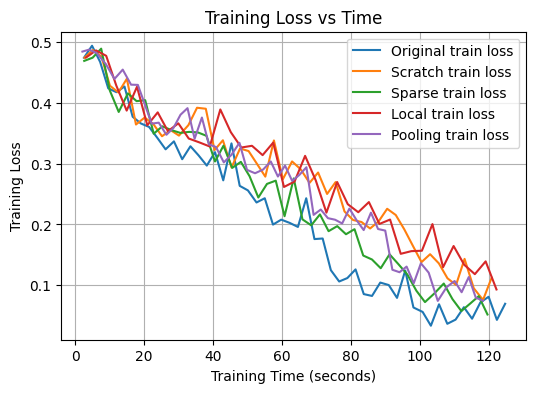

In [82]:
plot_metric("train loss vs time", model_histories_final)

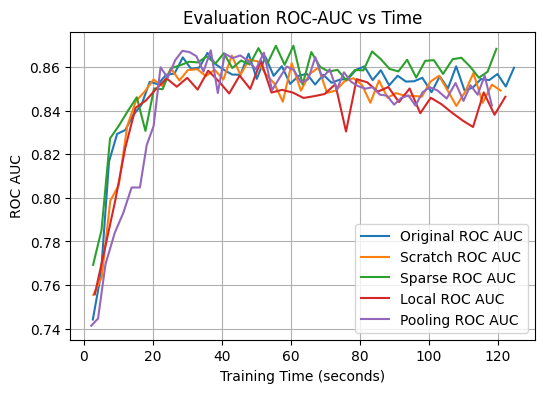

In [83]:
plot_metric("ROC vs time", model_histories_final)

In [84]:
training_times_final = summarize_training_times_and_memory_usage(model_histories_final)
training_times_final

,model name,full training time,average step time,average mem per step,average peak mem per step
0,Original,124.783765,0.094843,78.775916,1578.686139
1,Scratch,120.882672,0.099534,22.876160,1737.019989
2,Sparse,119.661810,0.101017,22.862314,1736.795354
3,Local,122.271673,0.122692,22.876224,2813.820685
4,Pooling,118.359967,0.082084,625.319871,1839.702509


In [76]:
model_state_dicts_500 = {"Original": "adult_models/nanotabpfn_original.pt", 
                   "Scratch": "adult_models/nanotabpfn_scratch_attention.pt", 
                   "Sparse": "adult_models/nanotabpfn_sparse_attention.pt",
                   "Local": "adult_models/nanotabpfn_local_attention.pt", 
                   "Pooling":"adult_models/nanotabpfn_pooling_attention.pt" }

In [77]:
from visualisation import  collect_inference_times
inferences_500 = collect_inference_times(model_state_dicts_500)

adult_models/nanotabpfn_original.pt Original
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_original.pt Original
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_original.pt Original
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_original.pt Original
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_scratch_attention.pt Scratch
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_scratch_attention.pt Scratch
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_scratch_attention.pt Scratch
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_scratch_attention.pt Scratch
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_sparse_attention.pt Sparse
local window size:  30
local window size:  30
local window size:  30
Finished iteration over all stored datasets! 
adult_models/nanotabpfn_sparse_attention.pt Sparse
local window size:  30


In [79]:
import pandas as pd

time_cols = [
    'inference time for 40 rows',
    'inference time for 100 rows',
    'inference time for 500 rows',
    'inference time for 1000 rows'
]

inferences_500[time_cols] = inferences_500[time_cols] * 1000

In [80]:
inferences_500

,model name,inference time for 40 rows,inference time for 100 rows,inference time for 500 rows,inference time for 1000 rows
0,Original,0.984347,0.768970,5.765370,14.748803
1,Scratch,0.530463,0.780267,5.914273,15.450709
2,Sparse,0.870566,0.929756,6.985560,20.066189
3,Local,0.470950,0.964551,5.202224,10.998576
4,Pooling,0.665752,0.659719,3.274442,7.574301
